# Calculate US Aplications Fraud Rate by Zip Code

In this dataset we have only 3 columns:
- zip code
- number of applications
- number of frauds

### Project Goal
- For each zip code, calculate the next-up hierarchical level fraud rate value.

We know that zip codes are organized in a way that we can expect that 90018 and 90025 should be relatively close, geographically speaking. 

We will break zip code column into 5 columns, here's an example for zip code 90018

- 8
- 18
- 018
- 0018
- 90018

and we will use the logistic smoothing formula in order to get more reliable results.

In [1]:
from datetime import datetime
start_time = datetime.now()
# LOAD LIBRARIES

import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

print('LOAD DURATION: ', datetime.now() - start_time) 

LOAD DURATION:  0:00:02.766690


In [2]:
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
#pd.set_option('display.width', 1000)

In [3]:
import math

In [4]:
data = pd.read_excel('/Users/markouskokovic/Desktop/Fall 2020/DSO 528/Homework/7/Fraud by zip code.xlsx', dtype=int)
data.head()

,zip,Applications,Frauds
0,6,7,2
1,9,25,7
2,23,7,3
3,26,20,6
4,27,21,2


In [5]:
data.dtypes

zip             int64
Applications    int64
Frauds          int64
dtype: object

In [6]:
data.describe()

,zip,Applications,Frauds
count,43581.000000,43581.000000,43581.000000
mean,49565.369037,26659.525757,92.370161
std,28339.811590,57125.509802,237.793013
min,6.000000,0.000000,0.000000
25%,25823.000000,405.000000,4.000000
50%,48618.000000,2501.000000,8.000000
75%,73654.000000,21222.000000,64.000000
max,99999.000000,662381.000000,7565.000000


In [7]:
data.shape

(43581, 3)

- Break down zip code colums as we mentioned in the intro

In [8]:
data['zip5'] = data['zip'].astype(str).str.zfill(5)
data['zip4'] = data.zip5.str[0:4]
data['zip3'] = data.zip5.str[0:3]
data['zip2'] = data.zip5.str[0:2]
data['zip1'] = data.zip5.str[0:1]
data.sample(10)

,zip,Applications,Frauds,zip5,zip4,zip3,zip2,zip1
36647,82242,143,5,82242,8224,822,82,8
16204,36202,649,26,36202,3620,362,36,3
13650,31066,2848,8,31066,3106,310,31,3
21798,48626,13346,9,48626,4862,486,48,4
11444,27356,7526,0,27356,2735,273,27,2
277,945,69,7,00945,0094,009,00,0
28910,64313,21,8,64313,6431,643,64,6
18359,41055,3547,8,41055,4105,410,41,4
12551,29290,560,7,29290,2929,292,29,2
9912,23651,1222,6,23651,2365,236,23,2


In [9]:
data.nunique()

zip             43581
Applications    16928
Frauds            844
zip5            43581
zip4             7525
zip3              988
zip2              100
zip1               10
dtype: int64

In [10]:
data.head()

,zip,Applications,Frauds,zip5,zip4,zip3,zip2,zip1
0,6,7,2,00006,0000,000,00,0
1,9,25,7,00009,0000,000,00,0
2,23,7,3,00023,0002,000,00,0
3,26,20,6,00026,0002,000,00,0
4,27,21,2,00027,0002,000,00,0


- As a starting point for a fraud rate, we will use US fraud rate

In [11]:
US_fraud_rate = data['Frauds'].sum() / data['Applications'].sum()
zip0_level = US_fraud_rate
zip0_level

0.0034648088698963847

In [12]:
# copy the data
data1 = data.copy()

- As we said we artificially created 5 levels of zip code

### Now we will groupby frauds and applications for each of the 5 zip code levels. Also, we will calculate fraud rate for each of the 5 zip code levels

- As an example, we will label number of frauds for level 1 'sumf1', for level 2 'sumf2',...
- we will label number of applications for level 1 'suma1', for level 2 'suma2',...
- we will label fraud rate for level 1 'fr1', for level 2 'fr2',...

In [13]:
for i in range(1,6):
    data1[f'sumf{i}'] = data1.groupby(f'zip{i}')['Frauds'].transform(sum)
    data1[f'suma{i}'] = data1.groupby(f'zip{i}')['Applications'].transform(sum)
    # if # applicants == 0, the division will result in inf
    data1[f'fr{i}'] = data1[f'sumf{i}'] / data1[f'suma{i}']
    # set inf to 0
    data1.loc[~np.isfinite(data1[f'fr{i}']), f'fr{i}'] = 0

In [14]:
data1['fr0_s'] = data1['Frauds'].sum()/data1['Applications'].sum()

In [15]:
data1

,zip,Applications,Frauds,zip5,zip4,zip3,zip2,zip1,sumf1,suma1,fr1,sumf2,suma2,fr2,sumf3,suma3,fr3,sumf4,suma4,fr4,sumf5,suma5,fr5,fr0_s
0,6,7,2,00006,0000,000,00,0,301121,95653900,0.003148,23533,7827973,0.003006,71,497,0.142857,9,32,0.281250,2,7,0.285714,0.003465
1,9,25,7,00009,0000,000,00,0,301121,95653900,0.003148,23533,7827973,0.003006,71,497,0.142857,9,32,0.281250,7,25,0.280000,0.003465
2,23,7,3,00023,0002,000,00,0,301121,95653900,0.003148,23533,7827973,0.003006,71,497,0.142857,11,48,0.229167,3,7,0.428571,0.003465
3,26,20,6,00026,0002,000,00,0,301121,95653900,0.003148,23533,7827973,0.003006,71,497,0.142857,11,48,0.229167,6,20,0.300000,0.003465
4,27,21,2,00027,0002,000,00,0,301121,95653900,0.003148,23533,7827973,0.003006,71,497,0.142857,11,48,0.229167,2,21,0.095238,0.003465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43576,99950,421,6,99950,9995,999,99,9,791855,209022682,0.003788,11846,4724581,0.002507,202,41305,0.004890,6,421,0.014252,6,421,0.014252,0.003465
43577,99979,21,6,99979,9997,999,99,9,791855,209022682,0.003788,11846,4724581,0.002507,202,41305,0.004890,6,21,0.285714,6,21,0.285714,0.003465
43578,99987,2,0,99987,9998,999,99,9,791855,209022682,0.003788,11846,4724581,0.002507,202,41305,0.004890,0,2,0.000000,0,2,0.000000,0.003465
43579,99998,20,7,99998,9999,999,99,9,791855,209022682,0.003788,11846,4724581,0.002507,202,41305,0.004890,16,320,0.050000,7,20,0.350000,0.003465


- Since now we have number of frauds, applications and fraud rate for each of the 5 zip code levels, we can apply the logistic smoothing formula and calculate the next-up hierarchical level fraud rate value.

- 'fr1_s' represents fraud score for zip code level 1 using smoothing. 
- 'fr5_s' represents fraud score for zip code level 5 (full zip code) using smoothing. 

In [16]:
def smoothing(fr0, fr1, n_app, nmid, c):
    return fr0 + (fr1 - fr0) / (1 + math.exp(-(n_app - nmid) / c))

In [17]:
nmid = 50
c = 10
for i in range(1,6):
    data1[f'fr{i}_s'] = data1[[f'fr{i-1}_s', f'fr{i}', f'suma{i}']].apply(lambda x:
                       smoothing(x[0], x[1], x[2], nmid, c), axis = 1)

In [18]:
data1

,zip,Applications,Frauds,zip5,zip4,zip3,zip2,zip1,sumf1,suma1,fr1,sumf2,suma2,fr2,sumf3,suma3,fr3,sumf4,suma4,fr4,sumf5,suma5,fr5,fr0_s,fr1_s,fr2_s,fr3_s,fr4_s,fr5_s
0,6,7,2,00006,0000,000,00,0,301121,95653900,0.003148,23533,7827973,0.003006,71,497,0.142857,9,32,0.281250,2,7,0.285714,0.003465,0.003148,0.003006,0.142857,0.162488,0.164138
1,9,25,7,00009,0000,000,00,0,301121,95653900,0.003148,23533,7827973,0.003006,71,497,0.142857,9,32,0.281250,7,25,0.280000,0.003465,0.003148,0.003006,0.142857,0.162488,0.171403
2,23,7,3,00023,0002,000,00,0,301121,95653900,0.003148,23533,7827973,0.003006,71,497,0.142857,11,48,0.229167,3,7,0.428571,0.003465,0.003148,0.003006,0.142857,0.181711,0.185015
3,26,20,6,00026,0002,000,00,0,301121,95653900,0.003148,23533,7827973,0.003006,71,497,0.142857,11,48,0.229167,6,20,0.300000,0.003465,0.003148,0.003006,0.142857,0.181711,0.187321
4,27,21,2,00027,0002,000,00,0,301121,95653900,0.003148,23533,7827973,0.003006,71,497,0.142857,11,48,0.229167,2,21,0.095238,0.003465,0.003148,0.003006,0.142857,0.181711,0.177201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43576,99950,421,6,99950,9995,999,99,9,791855,209022682,0.003788,11846,4724581,0.002507,202,41305,0.004890,6,421,0.014252,6,421,0.014252,0.003465,0.003788,0.002507,0.004890,0.014252,0.014252
43577,99979,21,6,99979,9997,999,99,9,791855,209022682,0.003788,11846,4724581,0.002507,202,41305,0.004890,6,21,0.285714,6,21,0.285714,0.003465,0.003788,0.002507,0.004890,0.019536,0.033419
43578,99987,2,0,99987,9998,999,99,9,791855,209022682,0.003788,11846,4724581,0.002507,202,41305,0.004890,0,2,0.000000,0,2,0.000000,0.003465,0.003788,0.002507,0.004890,0.004851,0.004811
43579,99998,20,7,99998,9999,999,99,9,791855,209022682,0.003788,11846,4724581,0.002507,202,41305,0.004890,16,320,0.050000,7,20,0.350000,0.003465,0.003788,0.002507,0.004890,0.050000,0.064228


In [33]:
data1['fr5_s'].describe()

count    43581.000000
mean         0.014153
std          0.030767
min          0.000000
25%          0.001962
50%          0.004183
75%          0.012028
max          0.595451
Name: fr5_s, dtype: float64

- We see that 75% of fraud scores are bellow 0.013

In [21]:
import seaborn as sns

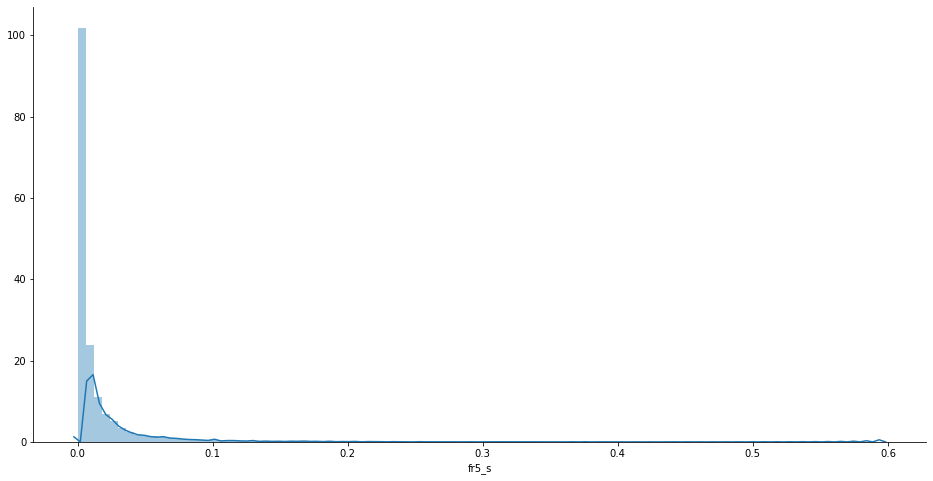

In [32]:
%matplotlib inline

plt.figure(figsize = (16,8))

sns.distplot(data1['fr5_s'], bins = 100)

sns.despine()

plt.show()

- What are the  50 zip codes with the highest fraud rate?

In [37]:
data1['fr5_s'].sort_values(ascending = False)[:50]

42033    0.595451
2543     0.505706
11961    0.504837
14554    0.458085
39011    0.453693
38812    0.452678
21647    0.443117
21456    0.421098
7569     0.415514
39010    0.406639
8515     0.383697
37911    0.378608
23504    0.376600
8036     0.375445
34435    0.374994
15527    0.374201
37914    0.372731
8520     0.371293
37910    0.367699
15941    0.366752
32949    0.366434
3831     0.364111
16639    0.363721
19544    0.363704
14555    0.362262
40121    0.360046
28912    0.348987
3638     0.346885
8518     0.345756
28910    0.345468
28911    0.344033
14553    0.343069
3696     0.340303
21602    0.340279
8541     0.338081
15092    0.337561
42996    0.337259
8027     0.335792
10137    0.335634
8519     0.333900
15093    0.333431
8517     0.333177
7570     0.332190
40120    0.331326
8025     0.329935
15089    0.328899
28909    0.328705
8516     0.327557
8026     0.326092
37915    0.324860
Name: fr5_s, dtype: float64

In [44]:
zip_codes_and_fraud_rates = pd.DataFrame(data1[['zip', 'fr5_s']])

In [45]:
zip_codes_and_fraud_rates

,zip,fr5_s
0,6,0.164138
1,9,0.171403
2,23,0.185015
3,26,0.187321
4,27,0.177201
...,...,...
43576,99950,0.014252
43577,99979,0.033419
43578,99987,0.004811
43579,99998,0.064228


In [46]:
zip_codes_and_fraud_rates.to_csv(r'zip_codes_and_fraud_rates2.csv')

In [43]:
zip_codes_and_fraud_rates.sort_index()

,fr5_s
0,0.164138
1,0.171403
2,0.185015
3,0.187321
4,0.177201
...,...
43576,0.014252
43577,0.033419
43578,0.004811
43579,0.064228


- We will visualise this result in tableau, so check it out to see in what part of USA fraud rates are the highest. 

In [19]:
print('duration: ', datetime.now()-start_time)

duration:  0:00:11.919795
